In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

In [2]:
data = pd.read_csv('FinalFeatures.csv', index_col='SUBJECT_ID')
data = data.dropna()
data.head()

,median_HR,mean_HR,std_HR,max_HR,min_HR,median_RR,mean_RR,std_RR,max_RR,min_RR,...,median_Temp,mean_Temp,std_Temp,max_Temp,min_Temp,mean RR interval,std RR interval,max RR interval,min RR interval,Ground_truth
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
20,80.0,79.121951,2.461657,80.0,67.0,16.0,15.404762,5.132676,27.0,10.0,...,36.299999,36.545714,0.539795,37.299999,35.900002,295.028550,102.574601,1088.0,200.0,0
33,64.0,64.324324,7.659613,100.0,53.0,16.0,16.756757,3.192051,24.0,10.0,...,36.999999,36.904040,0.339836,37.444445,36.333334,361.752227,129.275808,1744.0,200.0,1
79,89.0,88.441860,6.119066,101.0,78.0,18.0,18.046512,3.323463,24.0,11.0,...,37.222222,37.181818,0.338926,37.833332,36.666667,371.304148,128.696796,1344.0,200.0,0
85,102.5,103.193548,8.772349,136.0,79.0,23.0,22.364341,7.472803,39.0,9.0,...,37.333334,37.294974,0.739875,38.400002,35.900002,434.057682,325.856581,142360.0,200.0,0
123,58.5,61.000000,8.998575,80.0,43.0,16.0,16.225000,2.412441,22.0,11.0,...,36.050001,36.084127,0.571742,37.055554,35.299999,273.136960,70.078198,1392.0,200.0,0


In [3]:
print('Extracted features: ')
display.display(list(data.columns))
print('')
print('Number of patients: ' + str(data.shape[0]))
print('Number of features: ' + str(data.shape[1]))

Extracted features: 


['median_HR',
 'mean_HR',
 'std_HR',
 'max_HR',
 'min_HR',
 'median_RR',
 'mean_RR',
 'std_RR',
 'max_RR',
 'min_RR',
 'median_SpO2',
 'mean_SpO2',
 'std_SpO2',
 'max_SpO2',
 'min_SpO2',
 'median_Temp',
 'mean_Temp',
 'std_Temp',
 'max_Temp',
 'min_Temp',
 'mean RR interval',
 'std RR interval',
 'max RR interval',
 'min RR interval',
 'Ground_truth']


Number of patients: 6100
Number of features: 25


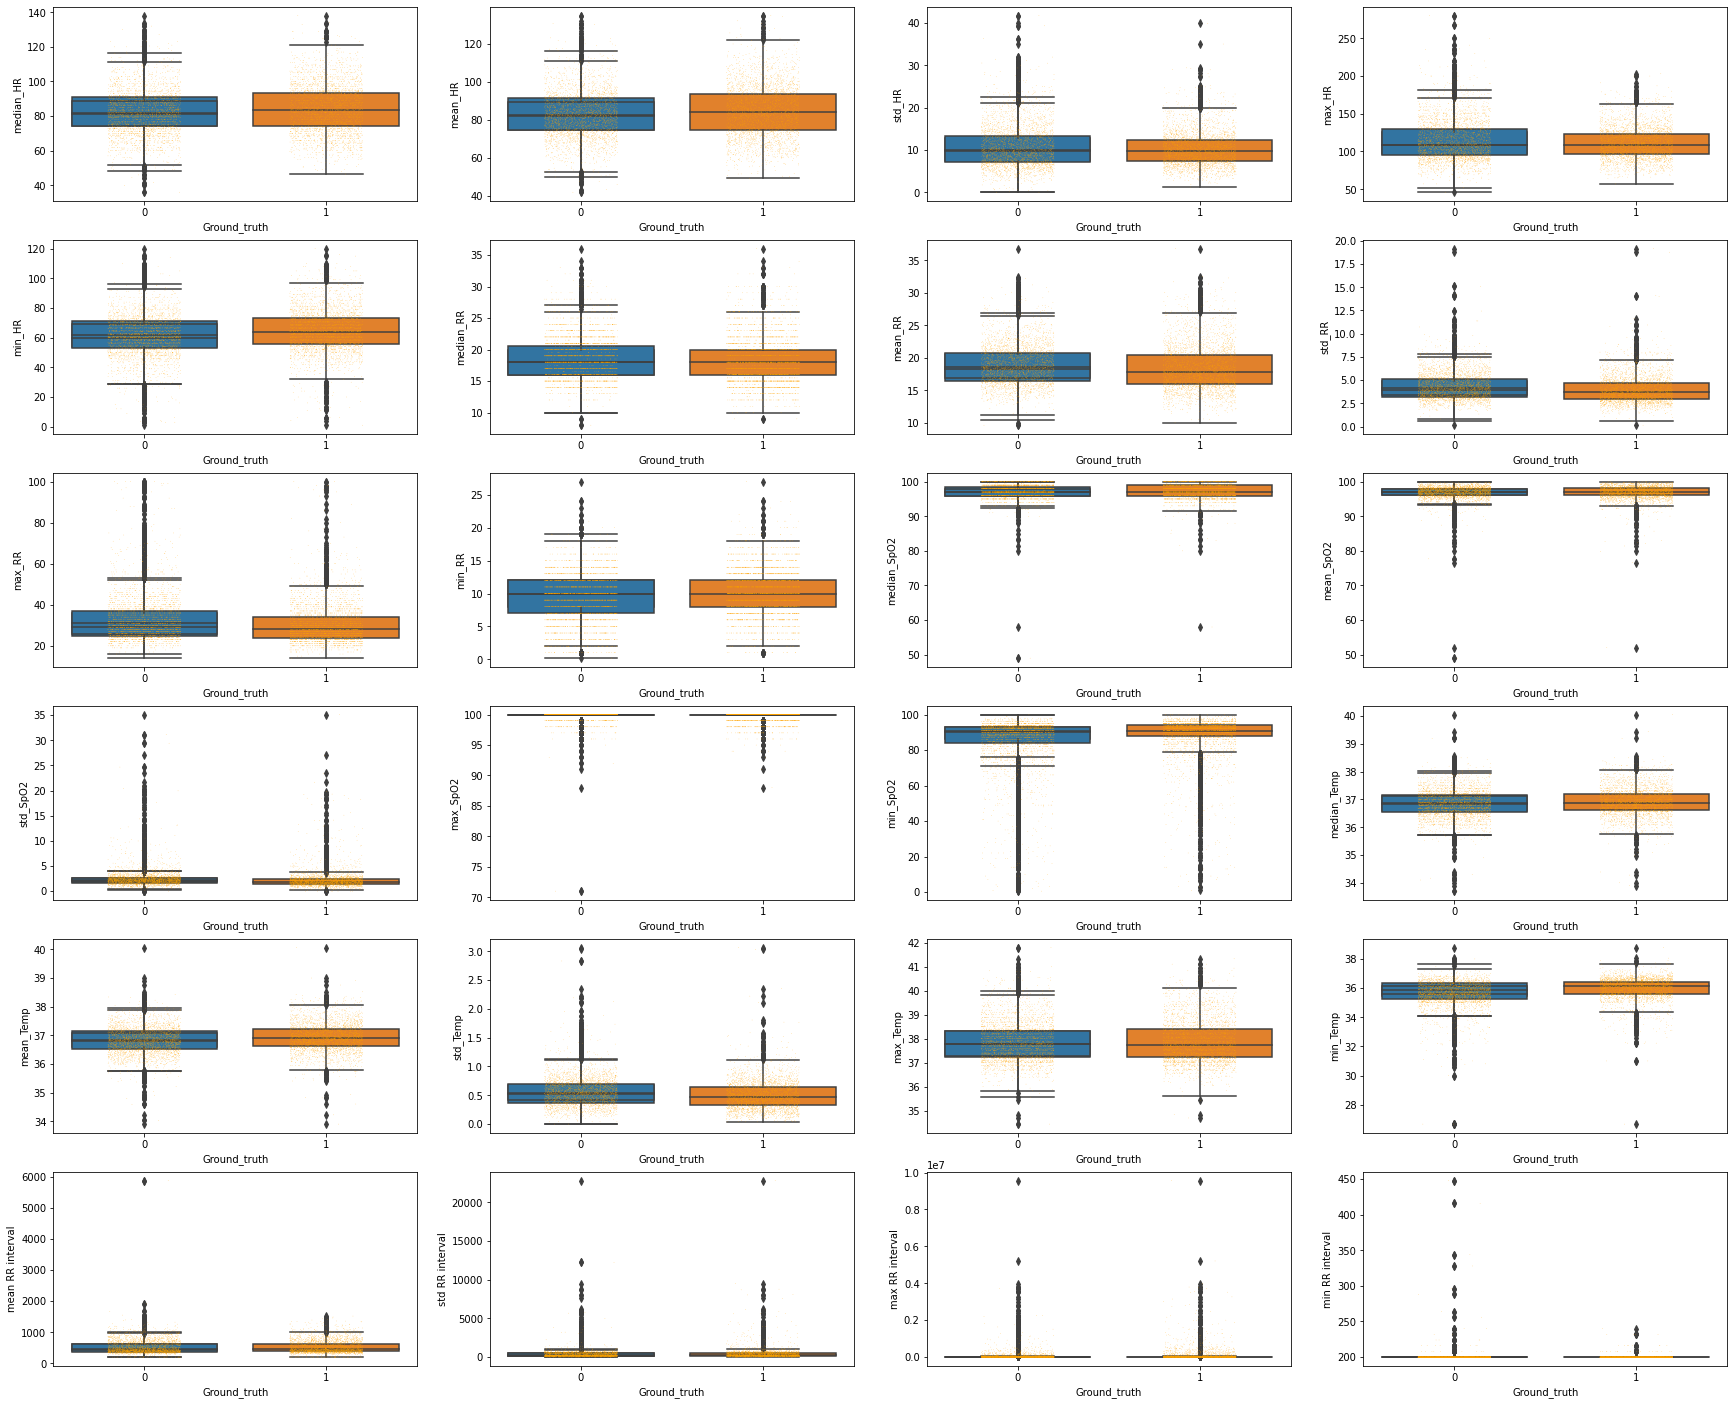

In [4]:
variables = ['median_HR','mean_HR','std_HR', 'max_HR', 'min_HR',
             'median_RR','mean_RR','std_RR', 'max_RR', 'min_RR',
             'median_SpO2','mean_SpO2','std_SpO2', 'max_SpO2','min_SpO2',
             'median_Temp','mean_Temp', 'std_Temp', 'max_Temp','min_Temp',
             'mean RR interval','std RR interval','max RR interval','min RR interval']

import seaborn as sns

fig = plt.figure(figsize=(30,25))
count = 0
for variable in variables:
    count += 1
    plt.subplot(6, 4, count)
    
    ax = sns.boxplot(y=variable, data=data)
    
    # same but partitioned by outcome
    ax = sns.boxplot(x = 'Ground_truth', y=variable, data=data)
    ax = sns.stripplot(x = 'Ground_truth', y=variable, data=data, color="orange", jitter=0.2, size=0.5)

plt.show()

In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data, data[['Ground_truth']], test_size = test_size, random_state = 10)

def print_size(y_train, y_test):
    print(str(len(y_train[y_train['Ground_truth']==1])) + '(' + str(round(len(y_train[y_train['Ground_truth']==1])/len(y_train)*100,1)) + '%)' + ' non-cardiac in training set')
    print(str(len(y_train[y_train['Ground_truth']==0])) + '(' + str(round(len(y_train[y_train['Ground_truth']==0])/len(y_train)*100,1)) + '%)' + ' cardiac in training set')
    print(str(len(y_test[y_test['Ground_truth']==1])) + '(' + str(round(len(y_test[y_test['Ground_truth']==1])/len(y_test)*100,1)) + '%)' + ' non-cardiac in test set')
    print(str(len(y_test[y_test['Ground_truth']==0])) + '(' + str(round(len(y_test[y_test['Ground_truth']==0])/len(y_test)*100,1)) + '%)' + ' cardiac in test set')
    
print_size(y_train, y_test)

2426(49.7%) non-cardiac in training set
2454(50.3%) cardiac in training set
624(51.1%) non-cardiac in test set
596(48.9%) cardiac in test set


In [86]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def performance(y, y_pred, print_ = 1, *args):   
    """ Calculate performance measures for a given ground truth classification y and predicted 
    probabilities y_pred. If *args is provided a predifined threshold is used to calculate the performance.
    If not, the threshold giving the best mean sensitivity and specificity is selected. The AUC is calculated
    for a range of thresholds using the metrics package from sklearn. """

    # xx and yy values for ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
    # area under the ROC curve
    AUC = metrics.auc(fpr, tpr)

    if args:
        threshold = args[0]
    else:
        # we will choose the threshold that gives the best balance between sensitivity and specificity
        difference = abs((1-fpr) - tpr)
        threshold = thresholds[difference.argmin()]        
        
    # transform the predicted probability into a binary classification
    y_pred[y_pred >= threshold] = 1
    y_pred[y_pred < threshold] = 0
  
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    # print the performance and plot the ROC curve    
    if print_ == 1:
        print('Threshold: ' + str(round(threshold,2)))
        print('TP: ' + str(tp))
        print('TN: ' + str(tn))
        print('FP: ' + str(fp))
        print('FN: ' + str(fn))
        print("Accuracy: " + str( round(accuracy, 2 )))
        print('Sensitivity: ' + str(round(sensitivity,2)))
        print('Specificity: ' + str(round(specificity,2)))                
        print('AUC: ' + str(round(AUC,2)))
    
        plt.figure(figsize = (4,3))
        plt.scatter(x = fpr, y = tpr, label = None)
        plt.plot(fpr, tpr, label = 'Classifier', zorder = 1)
        plt.plot([0, 1], [0, 1], 'k--', label = 'Random classifier')
        plt.scatter(x = 1 - specificity, y = sensitivity, c = 'black', label = 'Operating point', zorder = 2)
        plt.legend()
        plt.xlabel('1 - specificity')
        plt.ylabel('sensitivity')
        plt.show()
        

    return threshold, AUC, sensitivity, specificity

<ipython-input-7-df63ce53326d>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_max['Feature']= id_max['Feature'][-1]


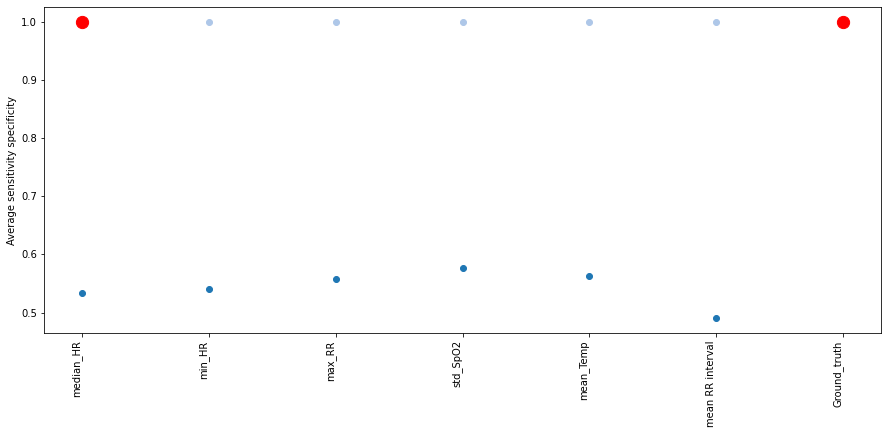

In [7]:
val_size = 0.4
X_train_SFS, X_val_SFS, y_train_SFS, y_val_SFS = train_test_split(X_train, y_train, test_size = val_size, random_state = 10)

from sklearn.linear_model import LogisticRegression
from matplotlib import cm
import time

#min_improv = 0.1
min_improv = 0.0005

#to_test_features = X_train_SFS.columns
to_test_features = X_train_SFS.columns[::4]
selected_features_sfs = []
test_set = []
results_selected = []
previous_perf = 0
gain = 1
it = 0

# create figure 
plt.figure(num=None, figsize=(15, 6))
plt.xticks(rotation='vertical', horizontalalignment='right')
plt.ylabel('Average sensitivity specificity')
colors = cm.tab20(np.linspace(0, 1, 180))
# just make sure you select an interval that gives you enough colors
colors = colors[::10]
    
# perform SFS while there is a gain in performance
while gain >= min_improv:
    frames = []
    color = colors[it]
    it += 1

    # add one feature at a time to the previously selected feature set.
    for col in to_test_features:
        test_set = selected_features_sfs.copy()
        test_set.append(col)
        
        # train model
        model = LogisticRegression(random_state = 1)
        model.fit(X_train_SFS[test_set], y_train_SFS.values.ravel())
             
        # test performance    
        y_pred_prob = model.predict_proba(X_val_SFS[test_set]) 
        _, AUC, sens, spec = performance(y_val_SFS, np.delete(y_pred_prob, 0, 1), print_ = 0)

        # save the results
        frames.append([test_set, (sens+spec)/2])
        
        # plot the performance
        plt.scatter(x = col, y = (sens+spec)/2, c = color)       
        display.display(plt.gcf())
        display.clear_output(wait=True)        
        time.sleep(0.001)

    # select best feature combination    
    results = pd.DataFrame(frames, columns=('Feature', 'Performance'))
    id_max = results.loc[results['Performance'].idxmax()]
    id_max['Feature']= id_max['Feature'][-1]
    gain = id_max['Performance'] - previous_perf
    
    # plot selected feature combination in red
    plt.scatter(x = id_max['Feature'], y = id_max['Performance'], c = 'red', s = 150)
    
    # test if selected feature combination improves the performance above predefined 'min_improv'
    if gain > min_improv:
        previous_perf = id_max['Performance']
        to_test_features = to_test_features.drop(id_max['Feature'])
        selected_features_sfs.append(id_max['Feature'])
        results_selected.append(id_max)
    # if not do not had the last feature to the feature set. Exit the loop

results_selected = pd.DataFrame(results_selected)

Threshold: 1
TP: 364
TN: 363
FP: 233
FN: 260
Accuracy: 0.6
Sensitivity: 0.58
Specificity: 0.61
AUC: 0.6


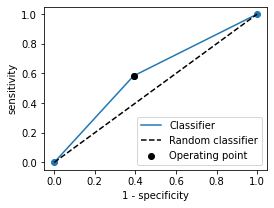

In [38]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate learning model
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance', metric = 'hamming')
#knn = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')

# fitting the model
knn.fit(X_train, y_train.values.ravel())

# predict the response
y_pred = knn.predict(X_test)

# evaluate the performance
threshold, AUC_test, sens_test, spec_test = performance(y_test, pd.DataFrame(y_pred), print_ = 1)

# save the results
all_results_train = pd.DataFrame()
all_results_test = pd.DataFrame()

#all_results_train = all_results_train.append(results_train.rename(index={results_train.index[-1]: 'KNN SFS'}))
#all_results_test = all_results_test.append(results_test.rename(index={results_test.index[-1]: 'KNN SFS'}))
#all_results_test.loc['KNN SFS'] = [threshold, AUC_test, sens_test, spec_test, len(selected_features_sfs)]
#all_results_train.loc['KNN SFS'] = np.nan

In [ ]:
all_results_test

In [11]:
def model_evaluation(model, X_train, y_train, X_test, y_test, print_):
    
    # tune - parameter estimation 
    print('TRAINING SET')
    y_pred_prob_train = model.predict_proba(X_train)
    threshold, AUC_train, sens_train, spec_train = performance(y_train, np.delete(y_pred_prob_train, 0, 1), print_)

    # test
    print('TEST SET')
    y_pred_prob_test = model.predict_proba(X_test)
    _, AUC_test, sens_test, spec_test = performance(y_test, np.delete(y_pred_prob_test, 0, 1), print_, threshold)
    
    # save the results
    results_train = pd.DataFrame(data = [[threshold, AUC_train, sens_train, spec_train, X_train.shape[1]]],
                           columns = ['Threshold','AUC', 'Sensitivity', 'Specificity', '# features'])

    results_test = pd.DataFrame(data = [[threshold, AUC_test, sens_test, spec_test, X_train.shape[1]]],
                           columns = ['Threshold','AUC', 'Sensitivity', 'Specificity', '# features'])
        
    return results_train, results_test, y_pred_prob_train, y_pred_prob_test

In [9]:
X_train=X_train.drop(['Ground_truth'], axis = 1) 

In [10]:
X_test=X_test.drop(['Ground_truth'], axis = 1) 

TRAINING SET
Threshold: 0.47
TP: 1771
TN: 1611
FP: 843
FN: 655
Accuracy: 0.69
Sensitivity: 0.73
Specificity: 0.66
AUC: 0.76


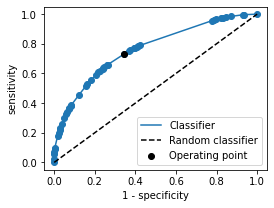

TEST SET
Threshold: 0.47
TP: 439
TN: 348
FP: 248
FN: 185
Accuracy: 0.65
Sensitivity: 0.7
Specificity: 0.58
AUC: 0.69


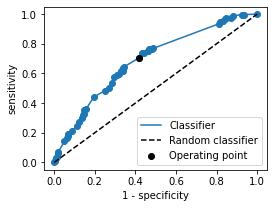

In [61]:
from sklearn.tree import DecisionTreeClassifier

clf_gini = DecisionTreeClassifier(criterion = 'gini', max_depth =6, min_samples_leaf = 20,
                                  min_samples_split = 20, random_state = 2, splitter = 'best')

clf_gini.fit(X_train, y_train)
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(clf_gini, X_train, y_train, X_test, y_test, print_ = 1)

TRAINING SET
Threshold: 0.46
TP: 2175
TN: 2199
FP: 255
FN: 251
Accuracy: 0.9
Sensitivity: 0.9
Specificity: 0.9
AUC: 0.96


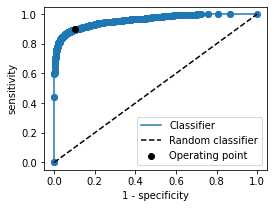

TEST SET
Threshold: 0.46
TP: 482
TN: 358
FP: 238
FN: 142
Accuracy: 0.69
Sensitivity: 0.77
Specificity: 0.6
AUC: 0.76


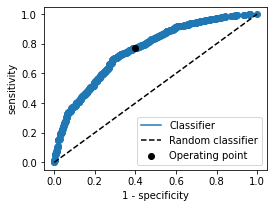

In [98]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, criterion = 'gini', 
                            max_depth = 10, random_state = 2)


rf.fit(X_train, y_train.values.ravel())
results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(rf, X_train, y_train, X_test, y_test, print_=1)


In [65]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm

# fit the model
clf = svm.SVC(kernel='rbf')

clf.fit(X_train,  y_train.values.ravel())

SVC()

In [66]:
y_pred = clf.predict(X_test)
#results_train, results_test, y_pred_prob_train, y_pred_prob_test = model_evaluation(clf, X_train, y_train, X_test, y_test, print_=1)

In [67]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))

Accuracy: 0.5098360655737705
Precision: 0.6326530612244898


In [68]:
from sklearn.metrics import confusion_matrix
CM=confusion_matrix(y_test,y_pred)
print(CM)

[[560  36]
 [562  62]]


In [79]:
CM = np.array([[507,155],[117,441]])
CM

array([[507, 155],
       [117, 441]])

Text(0.5, 1.0, 'Confusion Matrix')

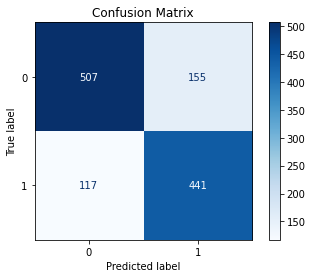

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=([0,1]))
disp.plot(cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')